In [4]:
import json
import ssl

import altair as alt
import cohere
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

ssl._create_default_https_context = ssl._create_unverified_context

In [5]:
with open('../keys.json', 'r') as f:
    api_key = json.load(f)['trial_api_key']

In [6]:
co = cohere.Client(api_key)

In [7]:
df_orig = pd.read_csv(
    'https://raw.githubusercontent.com/cohere-ai/notebooks/main/'
    'notebooks/data/atis_intents_train.csv', 
    names=['intent','query'])
print(df_orig.shape)
df_orig.head()

(4834, 2)


,intent,query
0,atis_flight,i want to fly from boston at 838 am and arriv...
1,atis_flight,what flights are available from pittsburgh to...
2,atis_flight_time,what is the arrival time in san francisco for...
3,atis_airfare,cheapest airfare from tacoma to orlando
4,atis_airfare,round trip fares from pittsburgh to philadelp...


In [8]:
sample_classes = ['atis_airfare', 'atis_airline', 'atis_ground_service']
df = df_orig[df_orig.intent.isin(sample_classes)].copy()
df.intent.unique()

array(['atis_airfare', 'atis_ground_service', 'atis_airline'],
      dtype=object)

In [9]:
df = df.sample(frac=0.1, random_state=1445)
df.reset_index(drop=True, inplace=True)
df_orig = df_orig.drop(df.index)  # ? why?
intents = df.pop('intent')
print(df.shape)
df.head()

(84, 1)


,query
0,what kind of ground transportation is there i...
1,dl 296 denver to philadelphia what is the fare
2,tell me about ground transportation in st. pe...
3,i'd like to have some information on a ticket...
4,could you tell me about ground transportation...


In [10]:
intents.unique()

array(['atis_ground_service', 'atis_airfare', 'atis_airline'],
      dtype=object)

In [11]:
def get_embeddings(
        texts: list,
        model='embed-english-v3.0',
        input_type='search_document'):
    output = co.embed(model=model, input_type=input_type, texts=texts)
    return output.embeddings

In [12]:
df['query_emb'] = get_embeddings(df['query'].tolist())
df.head()

,query,query_emb
0,what kind of ground transportation is there i...,"[-0.025115967, 0.029418945, -0.043640137, -0.0..."
1,dl 296 denver to philadelphia what is the fare,"[-0.011947632, 0.0035438538, -0.043060303, 0.0..."
2,tell me about ground transportation in st. pe...,"[0.014480591, 0.0079422, -0.028427124, -0.0112..."
3,i'd like to have some information on a ticket...,"[0.023040771, 0.018661499, -0.017852783, 0.005..."
4,could you tell me about ground transportation...,"[0.04083252, 0.014732361, -0.040771484, -0.036..."


In [13]:
def get_pcs(arr, n):
    pca = PCA(n_components=n)
    proj = pca.fit_transform(arr)
    return proj

In [14]:
emb = np.array(df.query_emb.tolist())
emb_pc = get_pcs(emb, 10)

In [15]:
emb_pc

array([[ 4.07133550e-01, -5.47967109e-02,  9.86124184e-02,
        -2.31824721e-01, -1.35535835e-01,  2.23980815e-01,
        -6.70649123e-02, -9.81960075e-02, -5.01377796e-03,
        -8.21579900e-03],
       [-2.50256311e-01, -9.95999167e-02, -1.42244374e-04,
        -1.66931096e-01, -1.71460513e-01,  6.83961416e-02,
         4.15312938e-02,  9.66132085e-02, -3.50907399e-02,
         5.77045642e-03],
       [ 2.36276863e-01, -1.00460044e-01,  3.46758345e-02,
         5.21714186e-02,  1.22889999e-01, -1.35451462e-01,
         5.91725872e-02, -2.64654496e-02,  6.28670253e-02,
         4.20621932e-02],
       [-2.33675008e-01, -1.06177354e-01,  1.25921578e-01,
        -1.58790185e-01,  2.46195349e-01,  2.51176557e-01,
         6.31823744e-02,  1.72524228e-01, -1.56674888e-01,
         2.06753630e-01],
       [ 1.18536219e-01, -3.34517673e-01,  7.87225840e-03,
         3.34654847e-01,  1.29846039e-02,  3.91543296e-02,
         1.20165892e-01,  5.51540805e-02, -1.25761302e-01,
         2.

In [16]:
intents

0     atis_ground_service
1            atis_airfare
2     atis_ground_service
3            atis_airfare
4     atis_ground_service
             ...         
79    atis_ground_service
80           atis_airfare
81           atis_airline
82    atis_ground_service
83           atis_airfare
Name: intent, Length: 84, dtype: object

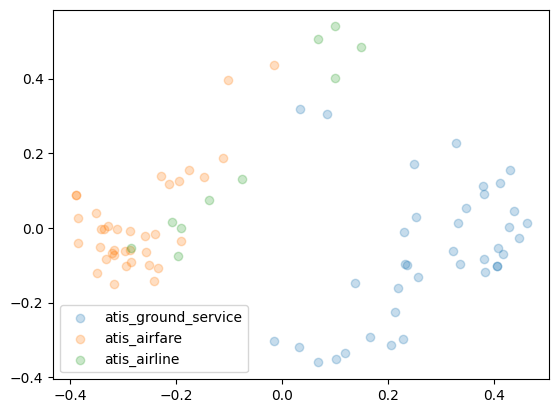

In [17]:
for intent in intents.unique():
    plt.scatter(
        emb_pc[intents[intents == intent].index, 0], 
        emb_pc[intents[intents == intent].index, 1], 
        alpha=0.25,
        label=intent)
plt.legend();

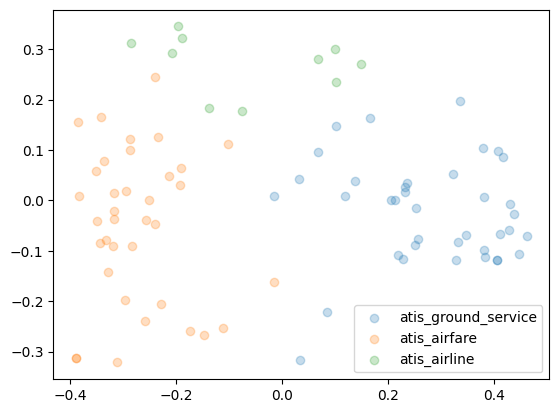

In [18]:
for intent in intents.unique():
    plt.scatter(
        emb_pc[intents[intents == intent].index, 0], 
        emb_pc[intents[intents == intent].index, 2], 
        alpha=0.25,
        label=intent)
plt.legend();

0      what kind of ground transportation is there i...
1        dl 296 denver to philadelphia what is the fare
2      tell me about ground transportation in st. pe...
3      i'd like to have some information on a ticket...
4      could you tell me about ground transportation...
5             show ground transportation for pittsburgh
6      what is the cheapest fare for flights from bo...
7      show me round trip fares between san francisc...
8      how long does the ground transportation take ...
9      please show me airlines with flights from den...
10     what ground transportation is available in sa...
11                 show me the car rentals in baltimore
12     how much does it cost to fly on delta from da...
13     what is the cost of united airlines flight 41...
14     is there ground transportation from the dalla...
15                                            is us air
16     round trip fares from baltimore to philadelph...
17     how much time does it take to go between 

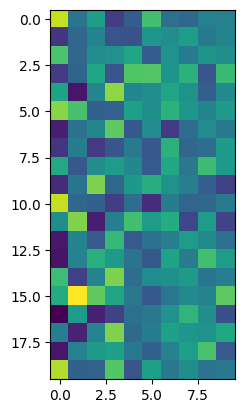

In [19]:
N = 20
labels = df['query'][:N]
plt.imshow(emb_pc[:N, :10])
print(labels)